In [163]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import time

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                         T, num_steps, N, seed=None):
    """Simulate N correlated GBM paths.  Return (N, num_steps+1, d)."""
    if seed is not None:
        np.random.seed(seed)

    d   = len(S0_vec)
    dt  = T / num_steps

    corr = rho * np.ones((d, d), dtype=np.float32)
    np.fill_diagonal(corr, 1.0)
    L = np.linalg.cholesky(corr)                       # (d,d) Cholesky

    S = np.zeros((N, num_steps + 1, d), dtype=np.float32)
    S[:, 0, :] = S0_vec

    drift  = (r - q_vec - 0.5 * sigma_vec**2) * dt
    vol_dt = sigma_vec * np.sqrt(dt)

    for t in range(num_steps):
        z_corr = np.random.randn(N, d).astype(np.float32) @ L.T
        S[:, t + 1, :] = S[:, t, :] * np.exp(drift + vol_dt * z_corr)

    return S


class ContinuationValueNet(nn.Module):
    """
    Neural network u^theta for continuation value
    """
    def __init__(self, d: int, width: int = None, depth: int = None,
                 negative_slope: float = 0.01, dropout: float = 0.1):
        super().__init__()
        self.d = d
        
        # Normalisation
        self.register_buffer('input_mean', torch.zeros(d + 1))
        self.register_buffer('input_std', torch.ones(d + 1))
        
        # Network
        layers = [nn.Linear(d + 1, width), nn.LeakyReLU(negative_slope)]
        
        for _ in range(depth - 2):
            layers.extend([
                nn.Linear(width, width),
                nn.LeakyReLU(negative_slope)
            ])
        
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)
        
        # Init weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def set_normalization(self, mean, std):
        self.input_mean.copy_(mean)
        self.input_std.copy_(std)
    
    def forward(self, t_norm: torch.Tensor, logS: torch.Tensor) -> torch.Tensor:
        x = torch.cat([t_norm.unsqueeze(-1), logS], dim=-1)
        x = (x - self.input_mean) / (self.input_std + 1e-8)
        return self.net(x).squeeze(-1)


@torch.no_grad()
def evaluate_policy(net, soft_sigma=0.2, N_eval=20_000):
    paths = simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                                 T, num_steps, N_eval)
    paths = torch.from_numpy(paths).to(device)
    B     = paths.size(0)

    normal  = Normal(0., 1.)
    survival      = torch.ones(B, device=device)
    total_payoffs = torch.zeros(B, device=device)
    disc_vec      = torch.exp(-r * dt * torch.arange(num_steps, device=device))

    for t in range(num_steps):
        t_norm   = t / num_steps
        S_t      = paths[:, t, :]
        payoff   = torch.clamp(S_t.max(dim=-1).values - K, min=0.)
        payoff_d = payoff * disc_vec[t]

        cont = net(torch.full((B,), t_norm, device=device),
                   torch.log(S_t + 1e-12))
        x    = (payoff_d - cont) / soft_sigma
        p_t  = normal.cdf(x)

        total_payoffs += survival * p_t * payoff_d
        survival       = survival * (1 - p_t)

    S_T     = paths[:, -1, :]
    payoffT = torch.clamp(S_T.max(dim=-1).values - K, min=0.)
    total_payoffs += survival * payoffT * np.exp(-r * T)

    mean = total_payoffs.mean().item()
    se   = total_payoffs.std(unbiased=True).item() / math.sqrt(N_eval)
    return mean, se


@torch.no_grad()
def evaluate_sharp_policy(net, N_eval=20_000, seed_eval=9999):
    net.eval()

    paths = simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                                 T, num_steps, N_eval, seed=seed_eval)
    paths = torch.from_numpy(paths).to(device)
    B     = paths.size(0)

    survival      = torch.ones(B, device=device)
    total_payoffs = torch.zeros(B, device=device)
    disc_vec      = torch.exp(-r * dt * torch.arange(num_steps, device=device))

    for t in range(num_steps):
        t_norm   = t / num_steps
        S_t      = paths[:, t, :]
        payoff   = torch.clamp(S_t.max(dim=-1).values - K, min=0.)
        payoff_d = payoff * disc_vec[t]

        cont = net(torch.full((B,), t_norm, device=device),
                   torch.log(S_t + 1e-12))

        exercise = (payoff_d > cont)
        total_payoffs += survival * exercise.float() * payoff_d
        survival       = survival * (~exercise).float()

    S_T     = paths[:, -1, :]
    payoffT = torch.clamp(S_T.max(dim=-1).values - K, min=0.)
    total_payoffs += survival * payoffT * np.exp(-r * T)

    mean = total_payoffs.mean().item()
    se   = total_payoffs.std(unbiased=True).item() / math.sqrt(N_eval)
    return mean, se


class EarlyStopping:
    """
    Early stopping to stop training when improvement small
    """
    
    def __init__(self, patience=20, min_delta=1e-4, relative_threshold=1e-3, 
                 min_epochs=50, max_epochs=2000):
        self.patience = patience
        self.min_delta = min_delta
        self.relative_threshold = relative_threshold
        self.min_epochs = min_epochs
        self.max_epochs = max_epochs
        
        self.best_score = -np.inf
        self.epochs_without_improvement = 0
        self.history = []
        self.start_time = None
        
    def start_training(self):
        self.start_time = time.time()
    
    def get_elapsed_time(self):
        if self.start_time is None:
            return 0
        return time.time() - self.start_time
    
    def format_time(self, seconds):
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)
        
        if hours > 0:
            return f"{hours}h {minutes}m {seconds}s"
        elif minutes > 0:
            return f"{minutes}m {seconds}s"
        else:
            return f"{seconds}s"
            
    def should_stop(self, current_score, epoch):
        self.history.append(current_score)
        
        if epoch < self.min_epochs:
            if current_score > self.best_score:
                self.best_score = current_score
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1
            return False
        
        if epoch >= self.max_epochs:
            elapsed_time = self.get_elapsed_time()
            print(f"Maximum epochs ({self.max_epochs}) reached after {self.format_time(elapsed_time)}. Stopping training.")
            return True
        
        absolute_improvement = current_score - self.best_score
        relative_improvement = absolute_improvement / abs(self.best_score) if self.best_score != 0 else 0
        
        is_improvement = (absolute_improvement > self.min_delta and 
                         relative_improvement > self.relative_threshold)
        
        if is_improvement:
            self.best_score = current_score
            self.epochs_without_improvement = 0
            return False
        else:
            self.epochs_without_improvement += 1
            
            if self.epochs_without_improvement >= self.patience:
                elapsed_time = self.get_elapsed_time()
                print(f"Early stopping triggered after {epoch + 1} epochs ({self.format_time(elapsed_time)})")
                print(f"Best score: {self.best_score:.6f}")
                print(f"No improvement for {self.patience} epochs")
                return True
        
        return False
    
    def get_best_score(self):
        return self.best_score
    
    def get_convergence_info(self):
        """
        Return information about the convergence process
        """
        return {
            'best_score': self.best_score,
            'epochs_without_improvement': self.epochs_without_improvement,
            'total_epochs': len(self.history),
            'final_score': self.history[-1] if self.history else None,
            'training_time': self.get_elapsed_time(),
            'training_time_formatted': self.format_time(self.get_elapsed_time())
        }


def train_net(soft_sigma,
              N_train=10_000,
              batch=500,
              lr=0.003,
              seed=None,
              eval_every=10,
              width=None,
              depth=None,
              dropout=0.1,
              curriculum=True,
              # Early stopping parameters
              patience=25,
              min_delta=1e-4,
              relative_threshold=1e-3,
              min_epochs=50,
              max_epochs=2000):
    """
    Train continuation‑value network
    """
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    net = ContinuationValueNet(d, width=width, depth=depth, dropout=dropout).to(device)
    optimiser = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimiser, mode='max', patience=15, factor=0.5, verbose=True, min_lr=1e-6
    )
    
    # Init early stopping
    early_stopping = EarlyStopping(
        patience=patience,
        min_delta=min_delta,
        relative_threshold=relative_threshold,
        min_epochs=min_epochs,
        max_epochs=max_epochs
    )
    
    normal = Normal(0., 1.)
    disc_vec = torch.exp(-r * dt * torch.arange(num_steps, device=device))

    steps_per_epoch = N_train // batch
    train_hist, eval_hist = [], []
    
    # Input normalization
    print("Setting up input normalization...")
    log_S0 = np.log(S0_vec[0])
    input_mean = torch.tensor([0.5] + [log_S0] * d, device=device)
    input_std = torch.tensor([0.3] + [0.3] * d, device=device)
    net.set_normalization(input_mean, input_std)
    
    if curriculum:
        def get_soft_sigma(ep):
            # Gradually decrease from 2*soft_sigma to soft_sigma over first 200 epochs
            if ep < 200:
                return soft_sigma * (2 - ep / 200)
            return soft_sigma
    else:
        get_soft_sigma = lambda ep: soft_sigma

    print(f"Starting training with early stopping (patience={patience}, min_epochs={min_epochs})")
    print(f"Will stop when improvement < {min_delta:.2e} absolute or < {relative_threshold:.2e} relative")
    
    early_stopping.start_training()
    
    ep = 0
    while True:
        current_soft_sigma = get_soft_sigma(ep)
        epoch_reward_sum = 0.0
        net.train()

        for _ in range(steps_per_epoch):
            S_b = torch.from_numpy(
                simulate_paths_multi(S0_vec, r, q_vec, sigma_vec, rho,
                                     T, num_steps, batch)
            ).to(device)
            B = S_b.size(0)

            logS = torch.log(S_b[:, :num_steps, :] + 1e-12)
            logS_f = logS.reshape(-1, d)
            t_norm = torch.arange(num_steps, device=device).repeat(B) / num_steps
            cont = net(t_norm, logS_f).view(B, num_steps)

            payoff_now = torch.clamp(S_b[:, :num_steps, :].max(dim=-1).values - K, 0.)
            payoff_disc = payoff_now * disc_vec.unsqueeze(0)

            survival = torch.ones(B, device=device)
            total_payoffs = torch.zeros(B, device=device)

            for t in range(num_steps):
                x_t = (payoff_disc[:, t] - cont[:, t]) / current_soft_sigma
                p_t = normal.cdf(x_t)

                total_payoffs += survival * p_t * payoff_disc[:, t]
                survival = survival * (1 - p_t)

            payoff_T = torch.clamp(S_b[:, -1, :].max(dim=-1).values - K, 0.)
            total_payoffs += survival * payoff_T * np.exp(-r * T)

            optimiser.zero_grad()
            loss = -total_payoffs.mean()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimiser.step()
            epoch_reward_sum += total_payoffs.mean().item()

        avg_reward = epoch_reward_sum / steps_per_epoch
        train_hist.append(avg_reward)
        
        # Evaluation and early stopping check
        if (ep + 1) % eval_every == 0:
            net.eval()
            eval_mean, _ = evaluate_policy(net, current_soft_sigma, N_eval=10_000)
            eval_hist.append((ep + 1, eval_mean))
            
            # Update learning rate scheduler
            scheduler.step(eval_mean)
            
            # Calculate elapsed time
            elapsed_time = early_stopping.get_elapsed_time()
            time_per_epoch = elapsed_time / (ep + 1)
            
            # print(f"Epoch {ep + 1:4d} | "
            #       f"train‑avg = {avg_reward:8.4f} | "
            #       f"soft‑eval = {eval_mean:8.4f} | "
            #       f"best = {early_stopping.get_best_score():8.4f} | "
            #       f"no_improve = {early_stopping.epochs_without_improvement:2d} | "
            #       f"time = {early_stopping.format_time(elapsed_time)} | "
            #       f"epoch_time = {time_per_epoch:.1f}s | "
            #       f"soft_sigma = {current_soft_sigma:.3f} | "
            #       f"lr = {optimiser.param_groups[0]['lr']:.2e}")
            
            # Check for early stopping
            if early_stopping.should_stop(eval_mean, ep + 1):
                break
        else:
            if early_stopping.should_stop(avg_reward, ep + 1):
                break
        
        ep += 1
    
    convergence_info = early_stopping.get_convergence_info()
    print(f"\nTraining completed after {ep + 1} epochs")
    print(f"Total training time: {convergence_info['training_time_formatted']}")
    print(f"Average time per epoch: {convergence_info['training_time'] / (ep + 1):.1f}s")
    print(f"Best evaluation score: {convergence_info['best_score']:.6f}")
    print(f"Final score: {convergence_info['final_score']:.6f}")
    
    return net, train_hist, eval_hist, convergence_info['training_time_formatted']

def average_time_in_seconds(times):
    """
    Helper function for checking training time
    """
    seconds = [float(t.strip('s')) for t in times]   
    avg = sum(seconds) / len(seconds)  
    return round(avg, 1)

# Option Parameters

In [5]:
# S0_vec       = np.full(d, 100.0, dtype=np.float32)
# sigma_vec    = np.full(d, 0.2, dtype=np.float32)
# q_vec        = np.full(d, 0.1, dtype=np.float32)
# rho          = 0.0
# r            = 0.05
# K            = 100.0
# T            = 3.0
# num_steps    = 9
# dt           = T / num_steps

NameError: name 'd' is not defined

# d = 2 (Asymm. Div)

In [15]:
d = 2
seed = 42

prices = []
times = []
n_trials = 8

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = np.full(d, 0.2, dtype=np.float32)
q_vec        = np.array([0.05, 0.15], dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg =  15.3463 | soft‑eval =  15.4480 | best =  15.3306 | no_improve =  0 | time = 0s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg =  15.4741 | soft‑eval =  15.4910 | best =  15.5884 | no_improve =  5 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg =  15.5026 | soft‑eval =  15.3555 | best =  15.8268 | no_improve =  6 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg =  15.4192 | soft‑eval =  15.9871 | best =  15.8268 | no_improve = 16 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg =  15.3353 | soft‑eval =  15.4575 | best =  15.9871 | no_improve =  9 | time = 2s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   60 | train

In [16]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 15.542 (0.004)
Max Price = 15.548
Times = ['10s', '23s', '11s', '12s', '11s', '21s', '9s', '16s']


In [17]:
times = ['10s', '23s', '11s', '12s', '11s', '21s', '9s', '16s']
print(f"Average training time = {average_time_in_seconds(times)}")

Average training time = 14.1


# d = 2 (Asymm. Div) Sigma Soft Test

In [165]:
d = 2
seed = 42

n_trials = 4

sigma_soft = np.logspace(-1, 1.7, num=12)
acc = []

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = np.full(d, 0.2, dtype=np.float32)
q_vec        = np.array([0.05, 0.15], dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps

for s in sigma_soft:
    prices = []
    times = []

    for trial in range(n_trials):
        net, train_hist, eval_hist, training_time = train_net(
        soft_sigma=s,
        N_train=10_000,
        batch=500,
        lr=0.007,
        seed=seed + trial,
        eval_every=10,
        width=64,
        depth=2,
        dropout=0.1,
        curriculum=False,
        patience=200,            
        min_delta=1e-2,      
        relative_threshold=1e-3,
        min_epochs=50,         
        max_epochs=2000     
        )
        times.append(training_time)
    
        print("\nEvaluating final policy...")
        sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
        prices.append(sharp_mean)
        print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")
    
    print("=======================================")
    print(f"Sigma Soft = {s:.3f}")
    print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
    print(f"Max Price = {np.max(prices):.3f}")
    print("=======================================")
    acc.append((np.mean(prices), np.std(prices), np.max(prices)))

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 285 epochs (10s)
Best score: 15.919025
No improvement for 200 epochs

Training completed after 284 epochs
Total training time: 10s
Average time per epoch: 0.0s
Best evaluation score: 15.919025
Final score: 15.197704

Evaluating final policy...
Sharp policy price ≈ 15.4429  CI: [15.4255,15.4602] (95% CI)
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 589 epochs (23s)
Best score: 16.305494
No improvement for 200 epochs

Training completed after 588 epochs
Total training time: 23s
Average time per epoch: 0.0s
Best evaluation score: 16.305494
Final score: 15.969384

Evaluating final policy...
Sharp policy price ≈ 15.5009  CI: [15.4841,15

In [166]:
sigma_soft

array([ 0.1       ,  0.17597645,  0.3096771 ,  0.54495876,  0.95899906,
        1.68761248,  2.96980048,  5.22614937,  9.19679199, 16.18418779,
       28.48035868, 50.11872336])

In [167]:
acc

[(15.373937845230103, 0.16209327489193548, 15.500861167907715),
 (15.421075582504272, 0.15001916236060775, 15.509710311889648),
 (15.521926403045654, 0.010282273381214216, 15.533257484436035),
 (15.530131340026855, 0.012052922986671986, 15.545076370239258),
 (15.535664081573486, 0.0112654046147396, 15.546310424804688),
 (15.54342794418335, 0.004287714344111217, 15.54901123046875),
 (15.541552543640137, 0.004972379738340285, 15.546425819396973),
 (15.541210412979126, 0.0033317588066676136, 15.546699523925781),
 (15.538328409194946, 0.00415381485654682, 15.542022705078125),
 (15.53195595741272, 0.007441624862730563, 15.544259071350098),
 (15.515091180801392, 0.015838079193604544, 15.537912368774414),
 (15.495837688446045, 0.01879598571318287, 15.524399757385254)]

In [168]:
import pandas as pd

In [169]:
cols = ["mean_acc", "std_acc", "max_acc"]
df = pd.DataFrame(acc, columns=cols)
df.insert(0, "sigma_soft", sigma_soft)  # add the parameter as the first column

styled = (
    df.style
      .format({"sigma_soft": "{:.3f}",
               "mean_acc":   "{:.3f}",
               "std_acc":    "{:.3f}",
               "max_acc":    "{:.3f}"})
      .hide(axis="index")                
      .set_table_styles(
          [{"selector": "th",
            "props": [("text-align", "center")]},
           {"selector": "td",
            "props": [("text-align", "center")]}])
)
styled


sigma_soft,mean_acc,std_acc,max_acc
0.100,15.374,0.162,15.501
0.176,15.421,0.150,15.510
0.310,15.522,0.010,15.533
0.545,15.530,0.012,15.545
0.959,15.536,0.011,15.546
1.688,15.543,0.004,15.549
2.970,15.542,0.005,15.546
5.226,15.541,0.003,15.547
9.197,15.538,0.004,15.542
16.184,15.532,0.007,15.544


<>:16: SyntaxWarning: invalid escape sequence '\h'
<>:16: SyntaxWarning: invalid escape sequence '\h'
/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_69766/2081451575.py:16: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("Mean Evaluation Value Function $\hat{V}_0^{\\theta}$")


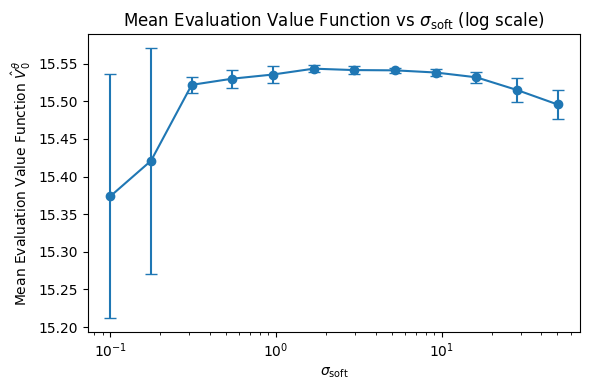

In [170]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.context(['science'])
plt.figure(figsize=(6, 4))

plt.errorbar(
    df["sigma_soft"],          # x
    df["mean_acc"],            # y
    yerr=df["std_acc"],        # ±1 σ
    fmt="o-",                  # markers + line
    capsize=4
)

plt.xscale("log")            
plt.xlabel(r"$\sigma_{\text{soft}}$")
plt.ylabel("Mean Evaluation Value Function $\hat{V}_0^{\\theta}$")
plt.title(r"Mean Evaluation Value Function vs $\sigma_{\text{soft}}$ (log scale)")
plt.tight_layout()
plt.show()


Python(80501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


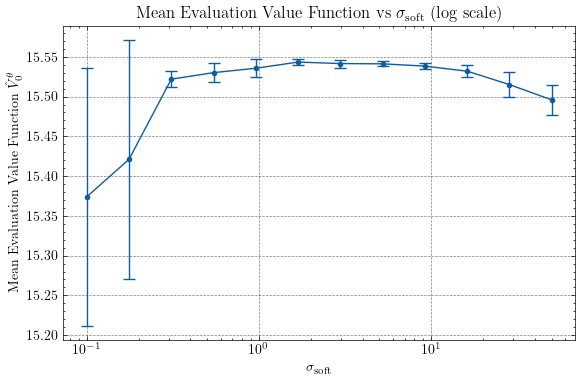

In [171]:
import matplotlib.pyplot as plt
import scienceplots               # pip install scienceplots

with plt.style.context(['science', 'grid']):   
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.errorbar(
        df["sigma_soft"],
        df["mean_acc"],
        yerr=df["std_acc"],
        fmt=".-",
        capsize=4,
    )

    ax.set_xscale("log")
    ax.set_xlabel(r"$\sigma_{\text{soft}}$")
    ax.set_ylabel(r"Mean Evaluation Value Function $\hat{V}_0^{\theta}$")
    ax.set_title(r"Mean Evaluation Value Function vs $\sigma_{\text{soft}}$ (log scale)")

    fig.tight_layout()
    plt.savefig('sigma_soft_div_max_call.pdf')

    plt.show();

In [150]:
d = 2
seed = 42

n_trials = 4

sigma_soft = np.logspace(-1, 1.5, num=6)
acc = []

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = np.full(d, 0.2, dtype=np.float32)
q_vec        = np.array([0.05, 0.15], dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps

for s in sigma_soft:
    prices = []
    times = []

    for trial in range(n_trials):
        net, train_hist, eval_hist, training_time = train_net(
        soft_sigma=s,
        N_train=10_000,
        batch=500,
        lr=0.007,
        seed=seed + trial,
        eval_every=10,
        width=64,
        depth=2,
        dropout=0.1,
        curriculum=False,
        patience=200,            
        min_delta=1e-2,      
        relative_threshold=1e-3,
        min_epochs=50,         
        max_epochs=2000     
        )
        times.append(training_time)
    
        print("\nEvaluating final policy...")
        sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
        prices.append(sharp_mean)
        print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")
    
    print("=======================================")
    print(f"Sigma Soft = {s:.3f}")
    print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
    print(f"Max Price = {np.max(prices):.3f}")
    print("=======================================")
    acc.append((np.mean(prices), np.std(prices), np.max(prices)))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 285 epochs (11s)
Best score: 15.919025
No improvement for 200 epochs

Training completed after 284 epochs
Total training time: 11s
Average time per epoch: 0.0s
Best evaluation score: 15.919025
Final score: 15.197704

Evaluating final policy...
Sharp policy price ≈ 15.4429  CI: [15.4255,15.4602] (95% CI)
Sigma Soft = 0.100
Price = 15.443 (0.000)
Max Price = 15.443


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> None

In [141]:
acc

[(15.537816762924194, 0.005199343353425672, 15.54438591003418),
 (15.537206888198853, 0.005804866266461506, 15.544830322265625),
 (15.535098632176718, 0.0074669822921103815, 15.544830322265625),
 (15.531806707382202, 0.011434185640625164, 15.544830322265625),
 (15.52798376083374, 0.014810440445858775, 15.544830322265625)]

In [142]:
sigma_soft

array([10.        , 13.33521432, 17.7827941 , 23.71373706, 31.6227766 ])

# d = 2 (Asymm. Vol)

In [36]:
def get_vol(d):
    if d <= 5:
        return np.array([0.08 + 0.32 * (i - 1) / (d - 1) for i in range(1,d + 1)], dtype=np.float32)
    else:
        return np.array([0.1 + i / (2*d) for i in range(1,d + 1)], dtype=np.float32)

In [43]:
get_vol(5)

array([0.08, 0.16, 0.24, 0.32, 0.4 ], dtype=float32)

In [44]:
d = 2
seed = 42

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg =  19.6807 | soft‑eval =  19.5880 | best =  19.9830 | no_improve =  4 | time = 0s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg =  19.6814 | soft‑eval =  19.6968 | best =  20.0247 | no_improve =  7 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg =  19.3176 | soft‑eval =  19.7459 | best =  20.3435 | no_improve =  7 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg =  19.2728 | soft‑eval =  19.6236 | best =  20.3435 | no_improve = 17 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg =  19.3174 | soft‑eval =  19.9785 | best =  20.3435 | no_improve = 27 | time = 2s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   60 | train

In [45]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 19.794 (0.003)
Max Price = 19.798
Times = ['13s', '12s', '14s', '17s']


In [68]:
Times = ['13s', '12s', '14s', '17s']
print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 14.0


In [46]:
d = 2
seed = 42

S0_vec       = np.full(d, 90.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg =  14.3164 | soft‑eval =  14.3499 | best =  14.9838 | no_improve =  4 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg =  14.2927 | soft‑eval =  14.2625 | best =  14.9838 | no_improve = 14 | time = 0s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg =  13.8938 | soft‑eval =  14.2701 | best =  14.9838 | no_improve = 24 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg =  13.8956 | soft‑eval =  14.3413 | best =  14.9838 | no_improve = 34 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg =  13.9112 | soft‑eval =  14.6117 | best =  14.9838 | no_improve = 44 | time = 1s | epoch_time = 0.0s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   60 | train

In [48]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 14.331 (0.007)
Max Price = 14.340
Times = ['10s', '38s', '10s', '17s']


In [69]:
Times = ['10s', '38s', '10s', '17s']
print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 18.8


# d = 3

In [78]:
d = 3
seed = 42

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps

prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 611 epochs (27s)
Best score: 27.587587
No improvement for 200 epochs

Training completed after 610 epochs
Total training time: 27s
Average time per epoch: 0.0s
Best evaluation score: 27.587587
Final score: 26.376560

Evaluating final policy...
Sharp policy price ≈ 26.6439  CI: [26.6152,26.6726] (95% CI)
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 256 epochs (10s)
Best score: 27.442592
No improvement for 200 epochs

Training completed after 255 epochs
Total training time: 10s
Average time per epoch: 0.0s
Best evaluation score: 27.442592
Final score: 27.153861

Evaluating final policy...
Sharp policy price ≈ 26.6198  CI: [26.5903,26

In [79]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 26.636 (0.012)
Max Price = 26.650
Times = ['27s', '10s', '12s', '11s']


In [87]:
Times = ['27s', '10s', '12s', '11s']
print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 15.0


In [80]:
d = 3
seed = 42

S0_vec       = np.full(d, 90.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 298 epochs (13s)
Best score: 19.732530
No improvement for 200 epochs

Training completed after 297 epochs
Total training time: 13s
Average time per epoch: 0.0s
Best evaluation score: 19.732530
Final score: 19.136751

Evaluating final policy...
Sharp policy price ≈ 19.0478  CI: [19.0233,19.0724] (95% CI)
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 506 epochs (22s)
Best score: 19.920550
No improvement for 200 epochs

Training completed after 505 epochs
Total training time: 22s
Average time per epoch: 0.0s
Best evaluation score: 19.920550
Final score: 18.583071

Evaluating final policy...
Sharp policy price ≈ 19.0422  CI: [19.0180,19

In [81]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 19.025 (0.030)
Max Price = 19.048
Times = ['13s', '22s', '12s', '12s']


In [88]:
Times = ['13s', '22s', '12s', '12s']

print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 14.8


# d = 5

In [82]:
d = 5
seed = 42

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 449 epochs (21s)
Best score: 38.855115
No improvement for 200 epochs

Training completed after 448 epochs
Total training time: 21s
Average time per epoch: 0.0s
Best evaluation score: 38.855115
Final score: 38.231800

Evaluating final policy...
Sharp policy price ≈ 37.9120  CI: [37.8792,37.9448] (95% CI)
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 602 epochs (28s)
Best score: 38.871948
No improvement for 200 epochs

Training completed after 601 epochs
Total training time: 28s
Average time per epoch: 0.0s
Best evaluation score: 38.871948
Final score: 37.953054

Evaluating final policy...
Sharp policy price ≈ 37.9105  CI: [37.8785,37

In [83]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 37.899 (0.020)
Max Price = 37.912
Times = ['21s', '28s', '18s', '18s']


In [89]:
Times = ['21s', '28s', '18s', '18s']

print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 21.2


In [84]:
d = 5
seed = 42

S0_vec       = np.full(d, 90.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 537 epochs (28s)
Best score: 28.543253
No improvement for 200 epochs

Training completed after 536 epochs
Total training time: 28s
Average time per epoch: 0.1s
Best evaluation score: 28.543253
Final score: 26.980859

Evaluating final policy...
Sharp policy price ≈ 27.6002  CI: [27.5713,27.6291] (95% CI)
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 385 epochs (19s)
Best score: 28.388719
No improvement for 200 epochs

Training completed after 384 epochs
Total training time: 19s
Average time per epoch: 0.1s
Best evaluation score: 28.388719
Final score: 27.750961

Evaluating final policy...
Sharp policy price ≈ 27.5823  CI: [27.5533,27

In [85]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 27.580 (0.022)
Max Price = 27.600
Times = ['28s', '19s', '17s', '24s']


In [90]:
Times = ['28s', '19s', '17s', '24s']

print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 22.0


# d = 10

In [62]:
d = 10
seed = 42

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 472 epochs (40s)
Best score: 106.733238
No improvement for 200 epochs

Training completed after 471 epochs
Total training time: 40s
Average time per epoch: 0.1s
Best evaluation score: 106.733238
Final score: 103.757770

Evaluating final policy...
Sharp policy price ≈ 104.2286  CI: [104.1482,104.3089] (95% CI)
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 524 epochs (44s)
Best score: 107.213708
No improvement for 200 epochs

Training completed after 523 epochs
Total training time: 44s
Average time per epoch: 0.1s
Best evaluation score: 107.213708
Final score: 103.712999

Evaluating final policy...
Sharp policy price ≈ 104.2416  CI: [

In [63]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 104.186 (0.049)
Max Price = 104.242
Times = ['40s', '44s', '37s', '39s']


In [91]:
Times = ['40s', '44s', '37s', '39s']

print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 40.0


In [64]:
d = 10
seed = 42

S0_vec       = np.full(d, 90.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 4

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 472 epochs (42s)
Best score: 87.885173
No improvement for 200 epochs

Training completed after 471 epochs
Total training time: 42s
Average time per epoch: 0.1s
Best evaluation score: 87.885173
Final score: 85.078569

Evaluating final policy...
Sharp policy price ≈ 85.6030  CI: [85.5314,85.6746] (95% CI)
Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Early stopping triggered after 524 epochs (46s)
Best score: 88.401685
No improvement for 200 epochs

Training completed after 523 epochs
Total training time: 46s
Average time per epoch: 0.1s
Best evaluation score: 88.401685
Final score: 85.323239

Evaluating final policy...
Sharp policy price ≈ 85.5438  CI: [85.4708,85

In [65]:
print(f"Price = {np.mean(prices):.3f} ({np.std(prices):.3f})")
print(f"Max Price = {np.max(prices):.3f}")
print(f"Times = {times}")

Price = 85.540 (0.048)
Max Price = 85.603
Times = ['42s', '46s', '40s', '40s']


In [92]:
Times = ['42s', '46s', '40s', '40s']

print(f"Average training time = {average_time_in_seconds(Times)}")

Average training time = 42.0


# d = 20

In [39]:
d = 20
seed = 42

S0_vec       = np.full(d, 100.0, dtype=np.float32)
sigma_vec    = get_vol(d)
q_vec        = np.full(d, 0.1, dtype=np.float32)
rho          = 0.0
r            = 0.05
K            = 100.0
T            = 3.0
num_steps    = 9
dt           = T / num_steps


prices = []
times = []
n_trials = 1

for trial in range(n_trials):
    net, train_hist, eval_hist, training_time = train_net(
    soft_sigma=2.0,
    N_train=10_000,
    batch=500,
    lr=0.007,
    seed=seed + trial,
    eval_every=10,
    width=64,
    depth=2,
    dropout=0.1,
    curriculum=False,
    patience=200,            
    min_delta=1e-2,      
    relative_threshold=1e-3,
    min_epochs=50,         
    max_epochs=2000     
    )
    times.append(training_time)

    print("\nEvaluating final policy...")
    sharp_mean, sharp_se = evaluate_sharp_policy(net, N_eval=5_000_000)
    prices.append(sharp_mean)
    print(f"Sharp policy price ≈ {sharp_mean:.4f}  CI: [{sharp_mean - 1.96*sharp_se:.4f},{sharp_mean + 1.96*sharp_se:.4f}] (95% CI)")

Setting up input normalization...
Starting training with early stopping (patience=200, min_epochs=50)
Will stop when improvement < 1.00e-02 absolute or < 1.00e-03 relative
Epoch   10 | train‑avg = 132.6036 | soft‑eval = 132.2347 | best = 129.2994 | no_improve =  0 | time = 1s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   20 | train‑avg = 142.3294 | soft‑eval = 142.9957 | best = 141.0061 | no_improve =  0 | time = 2s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   30 | train‑avg = 142.8824 | soft‑eval = 145.4027 | best = 143.9171 | no_improve =  5 | time = 3s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   40 | train‑avg = 143.4219 | soft‑eval = 144.6482 | best = 147.0524 | no_improve =  3 | time = 4s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   50 | train‑avg = 145.7536 | soft‑eval = 144.5944 | best = 147.0524 | no_improve = 13 | time = 5s | epoch_time = 0.1s | soft_sigma = 2.000 | lr = 7.00e-03
Epoch   60 | train

KeyboardInterrupt: 